Cybersecurity - Understanding the dataset

# **Load dataset and libraries**

In [ ]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, LancasterStemmer, WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag
import re

In [ ]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

In [ ]:
porter = nltk.PorterStemmer()
lancaster = nltk.LancasterStemmer()
wnl = WordNetLemmatizer()

In [ ]:
from urllib import request
from bs4 import BeautifulSoup
from nltk.corpus import stopwords

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load Data for review and understanding the structure

In [ ]:
cyber = pd.read_excel("/content/drive/MyDrive/CIS9665/TheHackerNews_Dataset.xlsx")

print(cyber.head())
print(cyber.shape)
print(cyber.columns)

                                               Title  \
0  Critical Cosmos Database Flaw Affected Thousan...   
1  Researchers Detail Modus Operandi of ShinyHunt...   
2  Chinese Hackers Believed to be Behind Second C...   
3  Using Breached Password Detection Services to ...   
4  Can Data Protection Systems Prevent Data At Re...   

                                                Link  \
0  https://thehackernews.com/2021/08/critical-cos...   
1  https://thehackernews.com/2021/08/researchers-...   
2  https://thehackernews.com/2021/06/chinese-hack...   
3  https://thehackernews.com/2021/06/using-breach...   
4  https://thehackernews.com/2021/05/can-data-pro...   

                                             Article          Label  
0  Cloud infrastructure security company Wiz on T...  Data_Breaches  
1  ShinyHunters, a notorious cybercriminal underg...  Data_Breaches  
2  Even as a massive data breach affecting Air In...  Data_Breaches  
3  Bolstering password policies in your organi

In [ ]:
list(cyber.columns)

['Title', 'Link', 'Article', 'Label']

In [ ]:
cyber.head(5)

,Title,Link,Article,Label
0,Critical Cosmos Database Flaw Affected Thousan...,https://thehackernews.com/2021/08/critical-cos...,Cloud infrastructure security company Wiz on T...,Data_Breaches
1,Researchers Detail Modus Operandi of ShinyHunt...,https://thehackernews.com/2021/08/researchers-...,"ShinyHunters, a notorious cybercriminal underg...",Data_Breaches
2,Chinese Hackers Believed to be Behind Second C...,https://thehackernews.com/2021/06/chinese-hack...,Even as a massive data breach affecting Air In...,Data_Breaches
3,Using Breached Password Detection Services to ...,https://thehackernews.com/2021/06/using-breach...,Bolstering password policies in your organizat...,Data_Breaches
4,Can Data Protection Systems Prevent Data At Re...,https://thehackernews.com/2021/05/can-data-pro...,Protection against insider risks works when th...,Data_Breaches


In [ ]:
cyber.shape

(3742, 4)

In [ ]:
len(cyber)

3742

In [ ]:
cyber["Article"].count()

np.int64(3742)

In [ ]:
cyber["Article"].isna().sum()

np.int64(0)

In [ ]:
cyber

,Title,Link,Article,Label
0,Critical Cosmos Database Flaw Affected Thousan...,https://thehackernews.com/2021/08/critical-cos...,Cloud infrastructure security company Wiz on T...,Data_Breaches
1,Researchers Detail Modus Operandi of ShinyHunt...,https://thehackernews.com/2021/08/researchers-...,"ShinyHunters, a notorious cybercriminal underg...",Data_Breaches
2,Chinese Hackers Believed to be Behind Second C...,https://thehackernews.com/2021/06/chinese-hack...,Even as a massive data breach affecting Air In...,Data_Breaches
3,Using Breached Password Detection Services to ...,https://thehackernews.com/2021/06/using-breach...,Bolstering password policies in your organizat...,Data_Breaches
4,Can Data Protection Systems Prevent Data At Re...,https://thehackernews.com/2021/05/can-data-pro...,Protection against insider risks works when th...,Data_Breaches
...,...,...,...,...
3737,Chinese hackers attack on White House computers,https://thehackernews.com/2012/10/chinese-hack...,The White House acknowledged Monday that one o...,Cyber_Attack
3738,Cyber Attacks on Six Major American Banks,https://thehackernews.com/2012/10/cyber-attack...,"According to reports, some of the United State...",Cyber_Attack
3739,9 million PCs infected with ZeroAccess botnet,https://thehackernews.com/2012/09/9-million-pc...,"In recent months, we've seen the rootkit famil...",Cyber_Attack
3740,Bharatiya Janata Party website defaced by Anon...,https://thehackernews.com/2012/09/bharatiya-ja...,Hackers from Indian Anonymous Group hacked Bha...,Cyber_Attack


# **Sentence and Word counts**

In [ ]:
raw_text = cyber["Article"].iloc[0]
print(raw_text)

Cloud infrastructure security company Wiz on Thursday revealed details of a now-fixed Azure Cosmos database vulnerability that could have been potentially exploited to grant any Azure user full admin access to other customers' database instances without any authorization.
The flaw, which grants read, write, and delete privileges, has been dubbed "ChaosDB," with Wiz researchers noting that "the vulnerability has a trivial exploit that doesn't require any previous access to the target environment, and impacts thousands of organizations, including numerous Fortune 500 companies."
Cosmos DB is Microsoft's proprietary NoSQL database that's advertised as "a fully managed service" that "takes database administration off your hands with automatic management, updates and patching."
The Wiz Research Team reported the issue to Microsoft on August 12, after which the Windows maker took steps to mitigate the issue within 48 hours of responsible disclosure, in addition to awarding a $40,000 bounty t

In [ ]:
import nltk
nltk.download('punkt_tab')

sentences = nltk.sent_tokenize(cyber["Article"].iloc[0])
print(sentences[:5])  # first 5 sentences

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


["Cloud infrastructure security company Wiz on Thursday revealed details of a now-fixed Azure Cosmos database vulnerability that could have been potentially exploited to grant any Azure user full admin access to other customers' database instances without any authorization.", 'The flaw, which grants read, write, and delete privileges, has been dubbed "ChaosDB," with Wiz researchers noting that "the vulnerability has a trivial exploit that doesn\'t require any previous access to the target environment, and impacts thousands of organizations, including numerous Fortune 500 companies."', 'Cosmos DB is Microsoft\'s proprietary NoSQL database that\'s advertised as "a fully managed service" that "takes database administration off your hands with automatic management, updates and patching."', 'The Wiz Research Team reported the issue to Microsoft on August 12, after which the Windows maker took steps to mitigate the issue within 48 hours of responsible disclosure, in addition to awarding a $4

In [ ]:
words = nltk.word_tokenize(cyber["Article"].iloc[0])
print(words[:20])  # first 20 words

['Cloud', 'infrastructure', 'security', 'company', 'Wiz', 'on', 'Thursday', 'revealed', 'details', 'of', 'a', 'now-fixed', 'Azure', 'Cosmos', 'database', 'vulnerability', 'that', 'could', 'have', 'been']


In [ ]:
words_clean = [w.lower() for w in words if w.isalpha()]
print(words_clean[:20])

['cloud', 'infrastructure', 'security', 'company', 'wiz', 'on', 'thursday', 'revealed', 'details', 'of', 'a', 'azure', 'cosmos', 'database', 'vulnerability', 'that', 'could', 'have', 'been', 'potentially']


In [ ]:
cyber["sent_count"] = cyber["Article"].apply(lambda x: len(nltk.sent_tokenize(x)))
print(cyber["sent_count"].head())

0    13
1    13
2    27
3    42
4    54
Name: sent_count, dtype: int64


In [ ]:
cyber.nlargest(5, "sent_count")[["Title", "sent_count"]]

,Title,sent_count
533,Everything You Need to Know About Evolving Thr...,116
3134,Everything You Need to Know About Evolving Thr...,116
1566,The Hacker News Hacking Awards : Best of Year ...,113
2900,The Hacker News Hacking Awards : Best of Year ...,113
3104,"Detecting the ""Next"" SolarWinds-Style Cyber At...",108


In [ ]:
cyber["word_count"] = cyber["Article"].apply(lambda x: len(nltk.word_tokenize(x)))
cyber[["sent_count", "word_count"]].describe()

,sent_count,word_count
count,3742.000000,3742.000000
mean,17.353821,523.136558
std,8.950151,236.216375
min,1.000000,24.000000
25%,12.000000,374.000000
50%,16.000000,496.000000
75%,20.000000,633.000000
max,116.000000,2664.000000


In [ ]:
def classify_article_length(word_count):
    if word_count < 100:
        return "short_alert"
    elif word_count < 800:
        return "medium_report"
    else:
        return "long_analysis"

cyber["article_type"] = cyber["word_count"].apply(classify_article_length)
cyber["article_type"].value_counts()

,count
article_type,
medium_report,3349
long_analysis,361
short_alert,32


In [ ]:
cyber["full_text"] = cyber["Title"] + " " + cyber["Article"]

cyber["full_word_count"] = cyber["full_text"].apply(
    lambda x: len(nltk.word_tokenize(x))
)

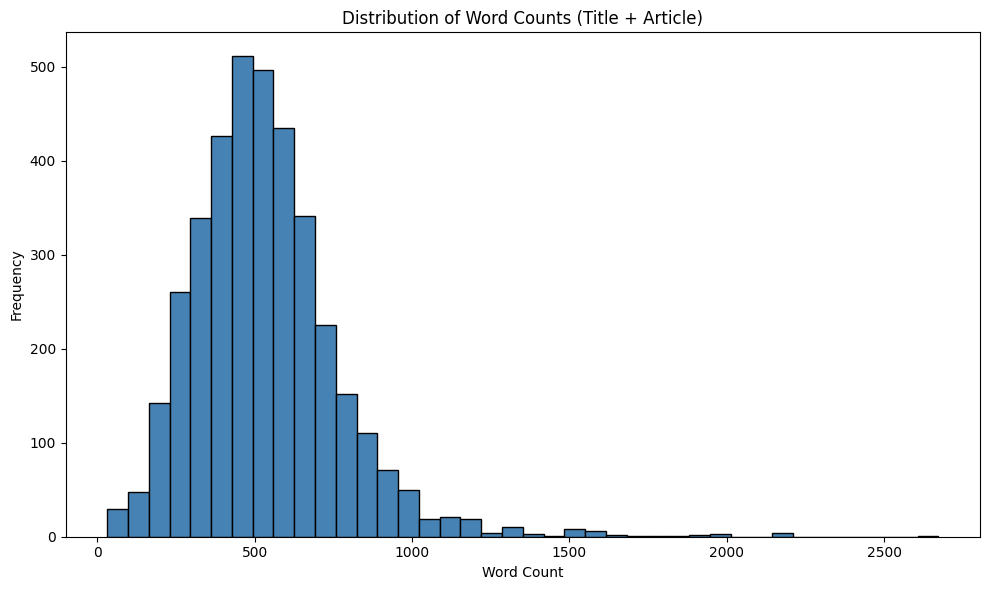

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(cyber["full_word_count"], bins=40, color='steelblue', edgecolor='black')
plt.title("Distribution of Word Counts (Title + Article)")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

In [ ]:
counts, bins, _ = plt.hist(cyber["full_word_count"], bins=40)
plt.close()  # Hide the plot since we only want the numbers

print("Bin edges:", bins)
print("Counts per bin:", counts)

Bin edges: [  32.   98.  164.  230.  296.  362.  428.  494.  560.  626.  692.  758.
  824.  890.  956. 1022. 1088. 1154. 1220. 1286. 1352. 1418. 1484. 1550.
 1616. 1682. 1748. 1814. 1880. 1946. 2012. 2078. 2144. 2210. 2276. 2342.
 2408. 2474. 2540. 2606. 2672.]
Counts per bin: [ 30.  48. 142. 260. 339. 426. 511. 496. 435. 341. 225. 152. 110.  71.
  50.  19.  21.  19.   4.  10.   3.   1.   8.   6.   2.   1.   1.   1.
   2.   3.   0.   0.   4.   0.   0.   0.   0.   0.   0.   1.]


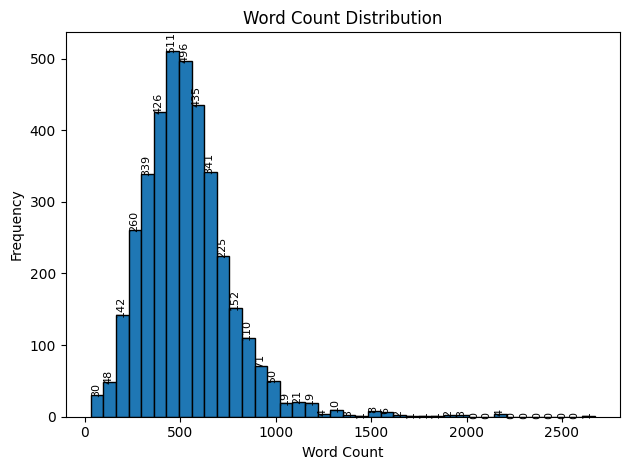

In [ ]:
import matplotlib.pyplot as plt

counts, bins, patches = plt.hist(cyber["full_word_count"], bins=40, edgecolor='black')

for count, bin_edge in zip(counts, bins[:-1]):
    plt.text(bin_edge, count, str(int(count)), fontsize=8, rotation=90)

plt.title("Word Count Distribution")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

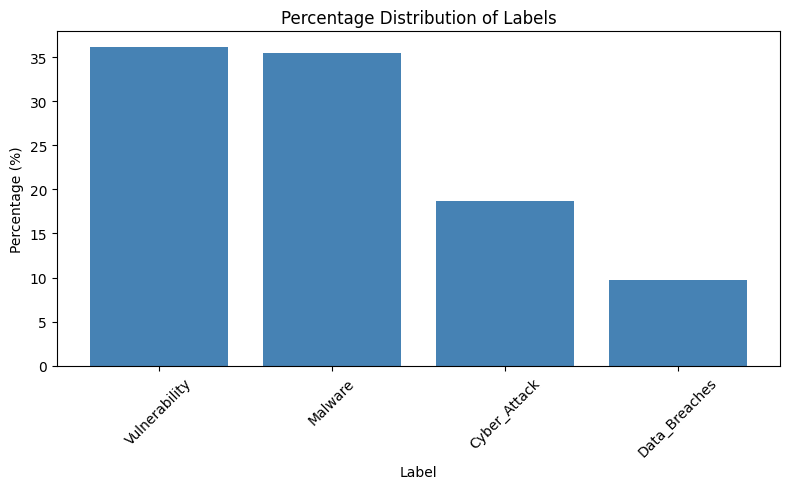

In [ ]:
import matplotlib.pyplot as plt

# Get percentage distribution
label_percent = cyber["Label"].value_counts(normalize=True) * 100

# Plot
plt.figure(figsize=(8, 5))
plt.bar(label_percent.index, label_percent.values, color='steelblue')
plt.title("Percentage Distribution of Labels")
plt.ylabel("Percentage (%)")
plt.xlabel("Label")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

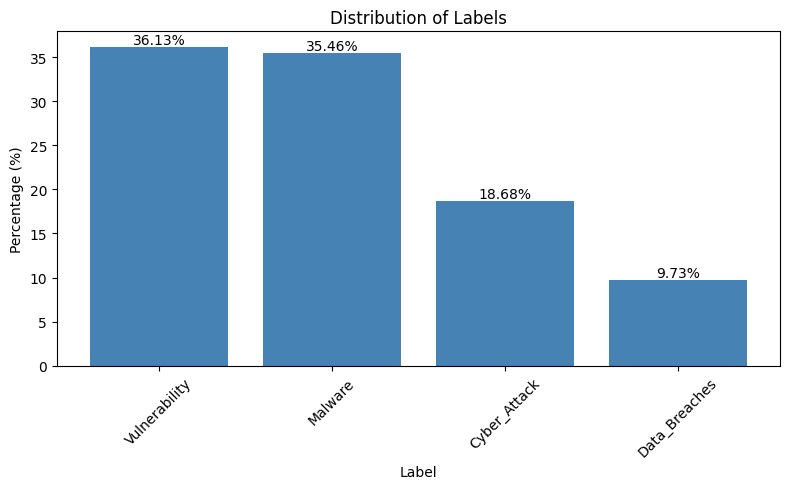

In [ ]:
import matplotlib.pyplot as plt

# Calculate percentage distribution
label_percent = cyber["Label"].value_counts(normalize=True) * 100

plt.figure(figsize=(8, 5))
bars = plt.bar(label_percent.index, label_percent.values, color='steelblue')

# Add percentage labels above each bar
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{height:.2f}%",
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.title("Distribution of Labels")
plt.ylabel("Percentage (%)")
plt.xlabel("Label")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

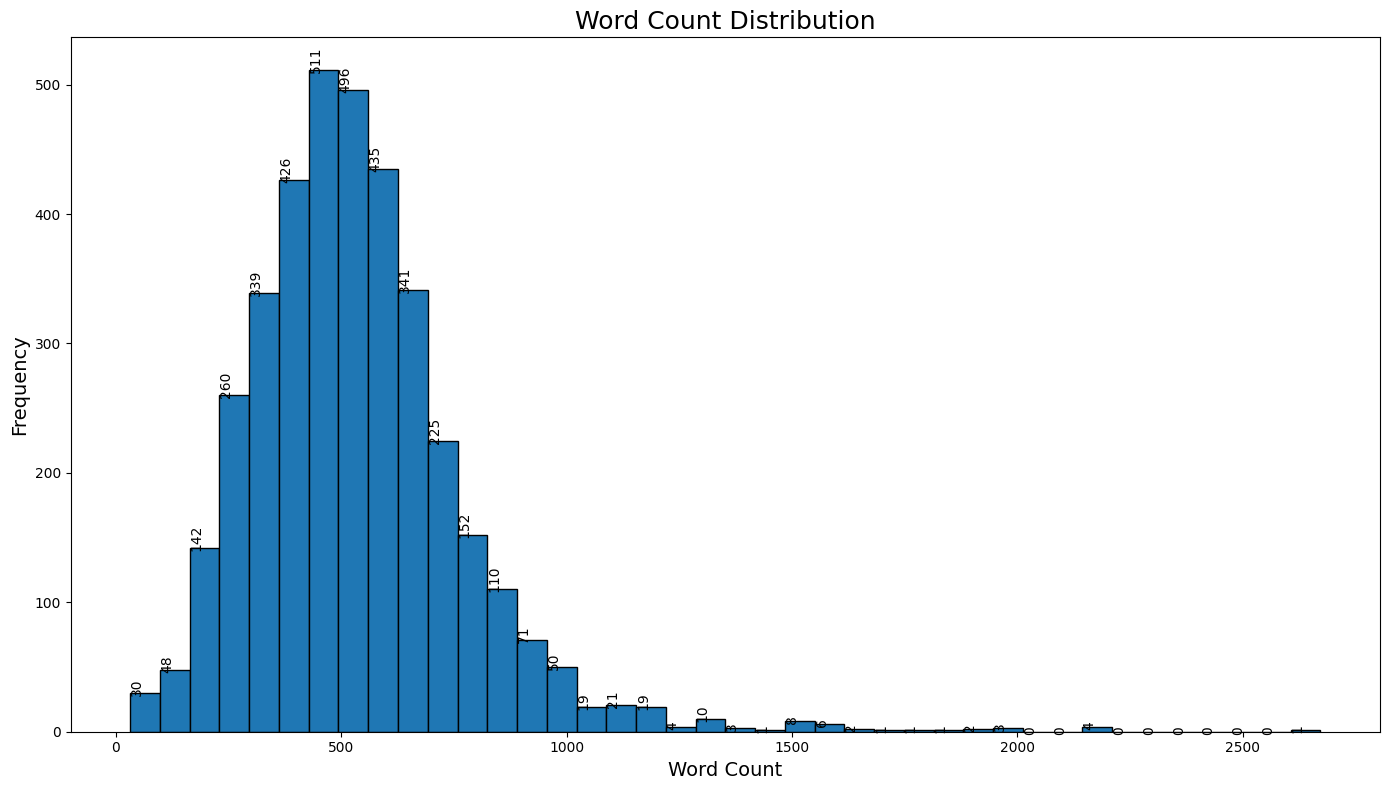

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 8))   # Increase width and height for presentation

counts, bins, patches = plt.hist(
    cyber["full_word_count"],
    bins=40,
    edgecolor='black'
)

for count, bin_edge in zip(counts, bins[:-1]):
    plt.text(bin_edge, count, str(int(count)), fontsize=10, rotation=90)

plt.title("Word Count Distribution", fontsize=18)
plt.xlabel("Word Count", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
cyber["full_word_count"].describe()

,full_word_count
count,3742.000000
mean,533.445484
std,236.626156
min,32.000000
25%,384.000000
50%,508.000000
75%,644.000000
max,2672.000000


In [ ]:
import numpy as np

data = cyber["full_word_count"]

five_num = {
    "min": np.min(data),
    "q1": np.percentile(data, 25),
    "median": np.percentile(data, 50),
    "q3": np.percentile(data, 75),
    "max": np.max(data)
}

five_num

{'min': 32,
 'q1': np.float64(384.0),
 'median': np.float64(508.0),
 'q3': np.float64(644.0),
 'max': 2672}

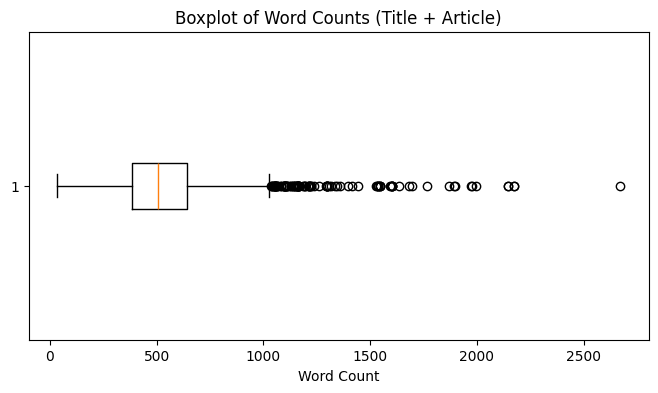

In [ ]:
plt.figure(figsize=(8, 4))
plt.boxplot(cyber["full_word_count"], vert=False)
plt.title("Boxplot of Word Counts (Title + Article)")
plt.xlabel("Word Count")
plt.show()

# **Start Cleaning Text - Chapter 3 (normalize, regex and remove non-alpha)**

In [ ]:
TEXT_COL = "Article"

def clean_text_basic(text):
    if pd.isna(text):
        return ""

    text = str(text)
    text = text.lower()

    text = re.sub(r'http\S+|www\.\S+', " ", text)
    text = re.sub(r"<.*?>", " ", text)
    text = re.sub(r"[^a-z0-9\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()

    return text

In [ ]:
cyber["Article_clean"] = cyber[TEXT_COL].apply(clean_text_basic)

In [ ]:
cyber[[TEXT_COL, "Article_clean"]].head(5)

,Article,Article_clean
0,Cloud infrastructure security company Wiz on T...,cloud infrastructure security company wiz on t...
1,"ShinyHunters, a notorious cybercriminal underg...",shinyhunters a notorious cybercriminal undergr...
2,Even as a massive data breach affecting Air In...,even as a massive data breach affecting air in...
3,Bolstering password policies in your organizat...,bolstering password policies in your organizat...
4,Protection against insider risks works when th...,protection against insider risks works when th...


In [ ]:
cyber = cyber[cyber["Article_clean"].str.len() > 0].copy()
cyber.shape

(3742, 8)

# **Tokenize and Remove Stopwords - Chapter 3**

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

nltk.download('punkt')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
len(stop_words), list(stop_words)[:20]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


(198,
 ['than',
  "they'd",
  'whom',
  "hadn't",
  'themselves',
  'them',
  'mustn',
  'you',
  'when',
  'after',
  'into',
  'is',
  'll',
  'hers',
  'that',
  'your',
  'ma',
  'the',
  'because',
  "they'll"])

Here I define the function that takes a clean string and tokenizes it, removes stopwords and keeps only alphabetic tokens as per chapter 3

In [ ]:
def tokenize_and_remove_stopwords(text):
    if not isinstance(text, str) or text.strip() == "":
        return []
    tokens = word_tokenize(text)
    filtered_tokens = [
        w.lower() for w in tokens
        if w.isalpha() and w.lower() not in stop_words
    ]

    return filtered_tokens

In [ ]:
cyber["Article_tokens"] = cyber["Article_clean"].apply(tokenize_and_remove_stopwords)

# NOTE: join back into a space separated string for later vectorization in notebook
cyber["Article_no_stop"] = cyber["Article_tokens"].apply(lambda toks: " ".join(toks))

In [ ]:
cyber[["Article_clean", "Article_tokens"]].head(3)

,Article_clean,Article_tokens
0,cloud infrastructure security company wiz on t...,"[cloud, infrastructure, security, company, wiz..."
1,shinyhunters a notorious cybercriminal undergr...,"[shinyhunters, notorious, cybercriminal, under..."
2,even as a massive data breach affecting air in...,"[even, massive, data, breach, affecting, air, ..."


In [ ]:
cyber[["Article_clean", "Article_no_stop"]].head(3)

,Article_clean,Article_no_stop
0,cloud infrastructure security company wiz on t...,cloud infrastructure security company wiz thur...
1,shinyhunters a notorious cybercriminal undergr...,shinyhunters notorious cybercriminal undergrou...
2,even as a massive data breach affecting air in...,even massive data breach affecting air india c...


# **Lemmatization with part of speech (POS) - Chapter 3 ARI/stemming exercise & Chapter 7**

In [ ]:
from nltk import pos_tag

lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

Function to Lemmatize the list of tokens

In [ ]:
def lemmatize_tokens(tokens):
    if not isinstance(tokens, list) or len(tokens) == 0:
        return []

    tagged = pos_tag(tokens)
    lemmas = [
        lemmatizer.lemmatize(word, get_wordnet_pos(pos))
        for word, pos in tagged
    ]

    return lemmas

Article_lemma_str → space-joined string (for TF-IDF / models)

In [ ]:

cyber["Article_lemmas"] = cyber["Article_tokens"].apply(lemmatize_tokens)
cyber["Article_lemma_str"] = cyber["Article_lemmas"].apply(lambda toks: " ".join(toks))

# Frequency, ngrams, pos counts, np chunks from Chap 3 and 7 notes

In [ ]:
from nltk import FreqDist

all_lemmas = []
for text in cyber["Article_lemma_str"]:
  if isinstance(text, str):
    all_lemmas.extend(text.split())

freq_dist = FreqDist(all_lemmas)
freq_dist.most_common(30)

[('use', 9918),
 ('security', 9219),
 ('user', 8800),
 ('attack', 8730),
 ('vulnerability', 7965),
 ('malware', 7654),
 ('system', 6670),
 ('researcher', 6047),
 ('data', 5901),
 ('also', 5799),
 ('say', 5649),
 ('attacker', 4943),
 ('hacker', 4909),
 ('device', 4750),
 ('server', 4628),
 ('exploit', 4606),
 ('file', 4372),
 ('company', 4337),
 ('information', 4270),
 ('target', 4263),
 ('code', 4194),
 ('malicious', 4164),
 ('access', 3972),
 ('include', 3875),
 ('could', 3738),
 ('network', 3608),
 ('new', 3560),
 ('computer', 3480),
 ('one', 3426),
 ('allow', 3386)]

In [ ]:
import matplotlib.pyplot as plt

freq_df = pd.DataFrame(freq_dist.most_common(30), columns=["word", "count"])
freq_df

,word,count
0,use,9918
1,security,9219
2,user,8800
3,attack,8730
4,vulnerability,7965
5,malware,7654
6,system,6670
7,researcher,6047
8,data,5901
9,also,5799


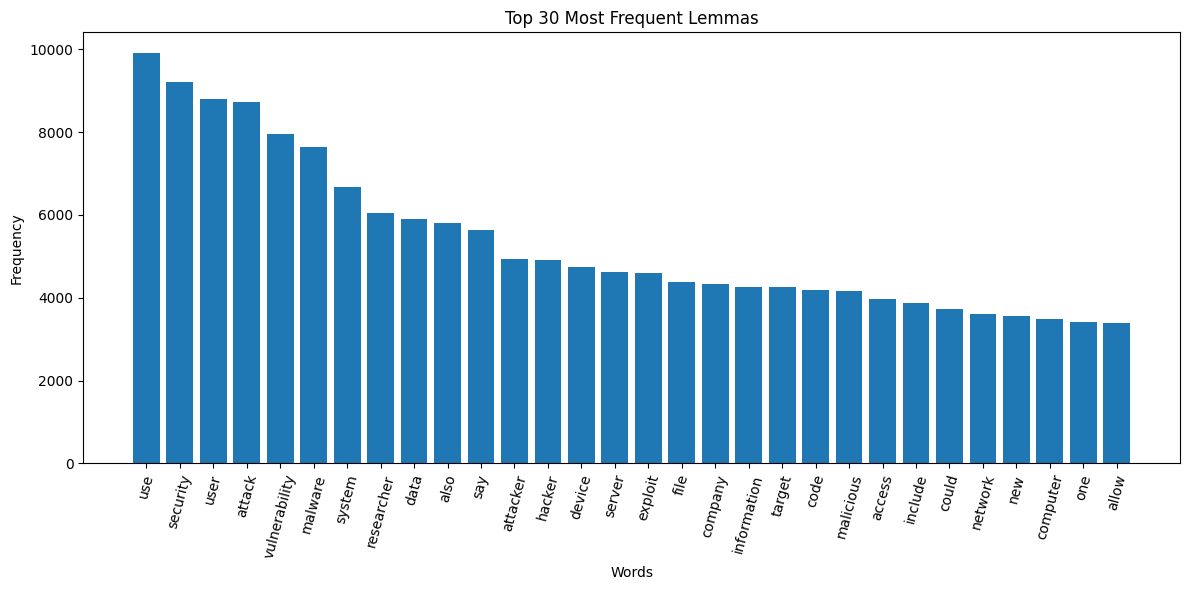

In [ ]:
import matplotlib.pyplot as plt

top_words = freq_dist.most_common(30)
words = [w for w, c in top_words]
counts = [c for w, c in top_words]

plt.figure(figsize=(12, 6))
plt.bar(words, counts)
plt.xticks(rotation=75)
plt.title('Top 30 Most Frequent Lemmas')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

Bigram & Trigram Frequencies

In [ ]:
from nltk import ngrams


bigrams = list(ngrams(all_lemmas, 2))
trigrams = list(ngrams(all_lemmas, 3))

bigram_freq = FreqDist(bigrams).most_common(20)
trigram_freq = FreqDist(trigrams).most_common(20)

bigram_freq, trigram_freq

([(('security', 'researcher'), 1386),
  (('zero', 'day'), 989),
  (('data', 'breach'), 922),
  (('allow', 'attacker'), 899),
  (('code', 'execution'), 826),
  (('cyber', 'attack'), 824),
  (('researcher', 'say'), 744),
  (('could', 'allow'), 740),
  (('operate', 'system'), 721),
  (('remote', 'code'), 664),
  (('last', 'year'), 607),
  (('blog', 'post'), 601),
  (('third', 'party'), 594),
  (('threat', 'actor'), 589),
  (('malicious', 'code'), 574),
  (('security', 'firm'), 557),
  (('ip', 'address'), 551),
  (('command', 'control'), 549),
  (('ddos', 'attack'), 506),
  (('hacker', 'news'), 505)],
 [(('remote', 'code', 'execution'), 651),
  (('zero', 'day', 'vulnerability'), 374),
  (('command', 'control', 'server'), 316),
  (('could', 'allow', 'attacker'), 293),
  (('c', 'c', 'server'), 256),
  (('code', 'execution', 'vulnerability'), 254),
  (('cross', 'site', 'script'), 210),
  (('google', 'play', 'store'), 208),
  (('execute', 'arbitrary', 'code'), 207),
  (('adobe', 'flash', 'play

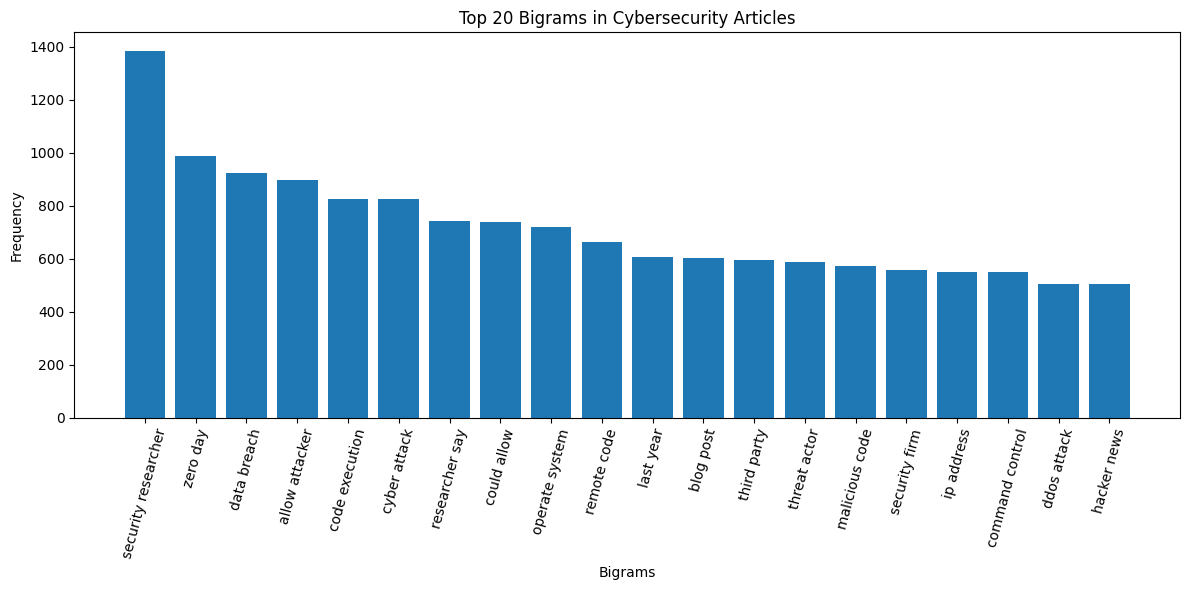

In [ ]:
# Separate items into text and counts for chart
bigrams_text = [' '.join(b) for b, c in bigram_freq]
bigrams_count = [c for b, c in bigram_freq]

plt.figure(figsize=(12, 6))
plt.bar(bigrams_text, bigrams_count)
plt.xticks(rotation=75)
plt.title('Top 20 Bigrams in Cybersecurity Articles')
plt.xlabel('Bigrams')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

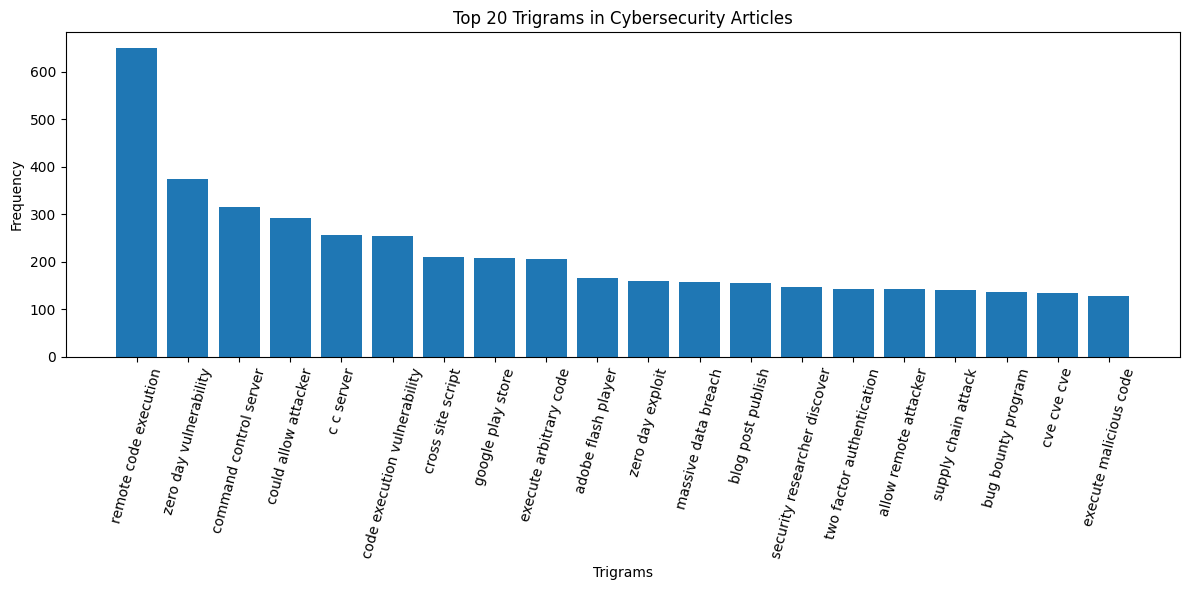

In [ ]:
trigrams_text = [' '.join(t) for t, c in trigram_freq]
trigrams_count = [c for t, c in trigram_freq]

plt.figure(figsize=(12, 6))
plt.bar(trigrams_text, trigrams_count)
plt.xticks(rotation=75)
plt.title('Top 20 Trigrams in Cybersecurity Articles')
plt.xlabel('Trigrams')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

POS tagging

In [ ]:
sample = cyber["Article_clean"].iloc[0]
tokens = nltk.word_tokenize(sample)
pos_tags = nltk.pos_tag(tokens)

pos_tags[:50]

[('cloud', 'JJ'),
 ('infrastructure', 'NN'),
 ('security', 'NN'),
 ('company', 'NN'),
 ('wiz', 'NN'),
 ('on', 'IN'),
 ('thursday', 'NN'),
 ('revealed', 'VBD'),
 ('details', 'NNS'),
 ('of', 'IN'),
 ('a', 'DT'),
 ('now', 'RB'),
 ('fixed', 'VBN'),
 ('azure', 'NN'),
 ('cosmos', 'NN'),
 ('database', 'NN'),
 ('vulnerability', 'NN'),
 ('that', 'WDT'),
 ('could', 'MD'),
 ('have', 'VB'),
 ('been', 'VBN'),
 ('potentially', 'RB'),
 ('exploited', 'VBN'),
 ('to', 'TO'),
 ('grant', 'VB'),
 ('any', 'DT'),
 ('azure', 'NN'),
 ('user', 'NN'),
 ('full', 'JJ'),
 ('admin', 'NN'),
 ('access', 'NN'),
 ('to', 'TO'),
 ('other', 'JJ'),
 ('customers', 'NNS'),
 ('database', 'VBP'),
 ('instances', 'NNS'),
 ('without', 'IN'),
 ('any', 'DT'),
 ('authorization', 'NN'),
 ('the', 'DT'),
 ('flaw', 'NN'),
 ('which', 'WDT'),
 ('grants', 'NNS'),
 ('read', 'VBP'),
 ('write', 'JJ'),
 ('and', 'CC'),
 ('delete', 'JJ'),
 ('privileges', 'NNS'),
 ('has', 'VBZ'),
 ('been', 'VBN')]

Chunking


In [ ]:
!pip install svgling

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 kB 5.6 MB/s eta 0:00:00


In [ ]:
grammar = r"""
    NP:
        {<DT>?<JJ.*>*<NN.*>+}          # basic pattern
        {<NNP.*>+}                     # proper noun groups (Microsoft, Azure Cosmos DB)
        {<NN.*><IN><NN.*>}             # "access to data"
        {<NN.*><CC><NN.*>}             # "malware and ransomware"
"""
cp = nltk.RegexpParser(grammar)
tree = cp.parse(pos_tags)


In [ ]:
def extract_nps(text):
    if not isinstance(text, str) or text.strip() == "":
        return []

    tokens = word_tokenize(text)
    tags = pos_tag(tokens)

    tree = cp.parse(tags)


    noun_phrases = [
        " ".join(word for word, tag in subtree.leaves())
        for subtree in tree.subtrees()
        if subtree.label() == "NP"
    ]

    return noun_phrases

In [ ]:
cyber["NP_chunks"] = cyber["Article_clean"].apply(
    lambda x: " ".join(extract_nps(x))
)

cyber["enhanced_text"] = cyber["Article_lemma_str"] + " " + cyber["NP_chunks"]

cyber[["Title", "Article_clean", "Article_lemma_str", "NP_chunks", "enhanced_text"]].head(3)

,Title,Article_clean,Article_lemma_str,NP_chunks,enhanced_text
0,Critical Cosmos Database Flaw Affected Thousan...,cloud infrastructure security company wiz on t...,cloud infrastructure security company wiz thur...,cloud infrastructure security company wiz thur...,cloud infrastructure security company wiz thur...
1,Researchers Detail Modus Operandi of ShinyHunt...,shinyhunters a notorious cybercriminal undergr...,shinyhunters notorious cybercriminal undergrou...,shinyhunters a notorious cybercriminal undergr...,shinyhunters notorious cybercriminal undergrou...
2,Chinese Hackers Believed to be Behind Second C...,even as a massive data breach affecting air in...,even massive data breach affect air india come...,a massive data breach air india the previous m...,even massive data breach affect air india come...


In [ ]:
tree

In [ ]:

cyber["NP_chunks"] = cyber["Article_clean"].apply(lambda x: " ".join(extract_nps(x)))

cyber["enhanced_text"] = cyber["Article_lemma_str"] + " " + cyber["NP_chunks"]


In [ ]:
cyber[["Title", "Article_clean", "Article_lemma_str", "NP_chunks", "enhanced_text"]].head(3)

,Title,Article_clean,Article_lemma_str,NP_chunks,enhanced_text
0,Critical Cosmos Database Flaw Affected Thousan...,cloud infrastructure security company wiz on t...,cloud infrastructure security company wiz thur...,cloud infrastructure security company wiz thur...,cloud infrastructure security company wiz thur...
1,Researchers Detail Modus Operandi of ShinyHunt...,shinyhunters a notorious cybercriminal undergr...,shinyhunters notorious cybercriminal undergrou...,shinyhunters a notorious cybercriminal undergr...,shinyhunters notorious cybercriminal undergrou...
2,Chinese Hackers Believed to be Behind Second C...,even as a massive data breach affecting air in...,even massive data breach affect air india come...,a massive data breach air india the previous m...,even massive data breach affect air india come...


Sentiment Analysis

In [ ]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

cyber["sentiment"] = cyber["enhanced_text"].apply(
    lambda x: sia.polarity_scores(x)["compound"] if isinstance(x, str) else 0)

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

cyber["sentiment"] = cyber["Article_clean"].apply(lambda x: sia.polarity_scores(x)["compound"])
cyber["sentiment"].describe()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,sentiment
count,3742.000000
mean,-0.337255
std,0.799613
min,-0.999800
25%,-0.976900
50%,-0.859750
75%,0.636800
max,0.999700


In [ ]:
cyber.groupby("Label")["sentiment"].mean().sort_values()

,sentiment
Label,
Cyber_Attack,-0.560212
Malware,-0.320455
Vulnerability,-0.317367
Data_Breaches,-0.044225


Step 3.1 — Most Frequent Words

1. Import Counter

Bar Chart

# Recap

In [ ]:
'''
+1.0 → Very positive
-1.0 → Very negative
~0.0 → Neutral'''

cyber["sentiment"] = cyber["Article_clean"].apply(lambda x: sia.polarity_scores(x)["compound"])

In [ ]:
cyber["sentiment"].describe()

,sentiment
count,3742.000000
mean,-0.337255
std,0.799613
min,-0.999800
25%,-0.976900
50%,-0.859750
75%,0.636800
max,0.999700


In [ ]:
cyber.nlargest(10, "sentiment")[["Title", "sentiment"]]
cyber.nsmallest(10, "sentiment")[["Title", "sentiment"]]

,Title,sentiment
1622,Its Fail 2011 - Year of Hacks !,-0.9998
533,Everything You Need to Know About Evolving Thr...,-0.9997
3134,Everything You Need to Know About Evolving Thr...,-0.9997
3511,WannaCry Kill-Switch(ed)? It's Not Over! Wanna...,-0.9996
2466,Anti-DDoS Services Abused to Carry Out DDoS At...,-0.9995
3528,Proposed Bill Would Legally Allow Cyber Crime ...,-0.9995
1859,Critical Flaws Found in VxWorks RTOS That Powe...,-0.9993
2017,"New 4G LTE Network Attacks Let Hackers Spy, Tr...",-0.9993
3423,"New 4G LTE Network Attacks Let Hackers Spy, Tr...",-0.9993
3714,"Cyber 9/11, cyber doomsday...between fear and ...",-0.9993


END OF EDA - JUDY